# Introduction

ZEISS is a German-based company specializing in the fields of optics and optoelectronics. It was started in 1846 by Carl Zeiss, and currently, it has 12,500 employees domestically and 30,000 employees internationally. In 2017, the company's annual revenue totaled more than 5.8 billion euros in its four segments: Industrial Quality & Research, Medical Technology, Consumer Markets, and Semiconductor Manufacturing Technology.

Information about ZEISS's stocks were accessed through Quandl, and the resulting dataset contains the following columns:
* **'Open'** - The price at which a stock is first traded during a day (Opening Price).
* **'High'** - The highest intra-day price for which a stock is traded.
* **'Low'** - The lowest intra-day price for which a stock is traded.
* **'Close'** - The price at which a stock is last traded during a day (Closing Price).
* **'Change'** - The difference between the opening and closing prices in a day.
* **'Traded Volume'** - The number of stocks traded in one day.
* **'Turnover'** - Also known as the "market cap", which is the price of one stock multiplied by the number of stocks circulating in the market.

In this project, I will do the following:
* **Access the data via the Quandl API**
* **Clean and fill in missing values**
* **Create a dashboard of the Closing Price, Change (Inter- and Intra-daily), Traded Volume, and Turnover using Bokeh.**
* **Estimate future values using Linear Regression.**

In [1]:
#Import the necessary modules
import requests
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import bokeh.io
import seaborn as sns
import fbprophet
from sklearn import metrics
import numpy as np

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


# 1) Importing the data

In [2]:
# Pull out information using the API_Key.
API_KEY = 'Ev3xeqQtKoSJk2z_t3We'
url = 'https://www.quandl.com/api/v3/datasets/FSE/AFX_X/data.json?api_key=' + API_KEY
r = requests.get(url)
json = r.json()

In [3]:
#Create dataframe using the json.
d = defaultdict(list)
columns = json['dataset_data']['column_names']

for x in json['dataset_data']['data']:
    for i in range(len(columns)):
        d[columns[i]].append(x[i])

dataframe = dict(d)

data = pd.DataFrame(dataframe)

In [4]:
#Examine the data
data.head()

,Date,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
0,2019-08-12,100.00,101.60,98.20,98.95,NaN,111146.0,11031779.0,None,None,NaN
1,2019-08-09,99.20,104.30,94.40,99.05,NaN,217386.0,21511178.0,None,None,NaN
2,2019-08-08,95.35,95.35,94.20,95.10,NaN,110482.0,10474803.0,None,None,NaN
3,2019-08-07,94.15,95.05,93.05,93.90,NaN,119157.0,11200026.0,None,None,NaN
4,2019-08-06,93.65,95.15,93.25,93.25,NaN,119714.0,11218618.0,None,None,NaN


In [5]:
data.tail()

,Date,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
4932,2000-06-13,NaN,NaN,NaN,45.0,NaN,0.0,NaN,None,None,0.0
4933,2000-06-12,NaN,NaN,NaN,45.0,NaN,0.0,NaN,None,None,0.0
4934,2000-06-09,NaN,NaN,NaN,45.0,NaN,0.0,NaN,None,None,0.0
4935,2000-06-08,NaN,NaN,NaN,38.0,NaN,0.0,NaN,None,None,0.0
4936,2000-06-07,NaN,NaN,NaN,38.0,NaN,0.0,NaN,None,None,0.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4937 entries, 0 to 4936
Data columns (total 11 columns):
Date                     4937 non-null object
Open                     4205 non-null float64
High                     4536 non-null float64
Low                      4536 non-null float64
Close                    4937 non-null float64
Change                   9 non-null float64
Traded Volume            4891 non-null float64
Turnover                 3582 non-null float64
Last Price of the Day    0 non-null object
Daily Traded Units       0 non-null object
Daily Turnover           1309 non-null float64
dtypes: float64(8), object(3)
memory usage: 424.4+ KB


From info(), I see several issues that would need to be addressed during the data cleaning step:
* Two blank columns (Last Price of the Day and Daily Traded Units)
* Change and Daily Turnover have a lot of missing values. Traded Volume and Turnover don't have as much of these, but they need to be addressed also.
* We don't need Open, High, and Low columns, so we'll delete them.

In [7]:
data.describe()

,Open,High,Low,Close,Change,Traded Volume,Turnover,Daily Turnover
count,4205.000000,4536.000000,4536.000000,4937.000000,9.000000,4.891000e+03,3.582000e+03,1309.0
mean,19.288821,22.864986,22.317997,22.590223,-0.008889,5.283628e+04,2.107757e+06,0.0
std,13.178175,17.815117,17.414915,17.187561,0.285633,7.565604e+04,5.330793e+06,0.0
min,4.200000,4.300000,4.050000,4.070000,-0.440000,0.000000e+00,1.980000e+03,0.0
25%,11.050000,11.410000,11.130750,11.360000,-0.120000,0.000000e+00,5.753455e+05,0.0
50%,15.560000,16.430000,16.010000,16.400000,-0.040000,3.897600e+04,1.039954e+06,0.0
75%,22.880000,24.567500,24.072500,24.930000,0.150000,7.275650e+04,2.019732e+06,0.0
max,100.300000,104.300000,99.300000,100.500000,0.420000,2.957391e+06,2.584535e+08,0.0


Here I see some more issues that need attention:
* Traded Volume and Turnover columns have a maximum value that approximately 100x the 75th percentile, suggesting an outlier.
* For the closing price, the max value is around 4x the 75th percentile.
* Daily Turnover appears to be entirely consisted of 0s.

# 2) Cleaning the data

### Converting Data column to datetime format and set as index.

In [8]:
# Currently, the "Date" Column is not in datetime format. We'll make it that and set it as index for easier access later.
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Open,High,Low,Close,Change,Traded Volume,Turnover,Last Price of the Day,Daily Traded Units,Daily Turnover
Date,,,,,,,,,,
2019-08-12,100.00,101.60,98.20,98.95,NaN,111146.0,11031779.0,None,None,NaN
2019-08-09,99.20,104.30,94.40,99.05,NaN,217386.0,21511178.0,None,None,NaN
2019-08-08,95.35,95.35,94.20,95.10,NaN,110482.0,10474803.0,None,None,NaN
2019-08-07,94.15,95.05,93.05,93.90,NaN,119157.0,11200026.0,None,None,NaN
2019-08-06,93.65,95.15,93.25,93.25,NaN,119714.0,11218618.0,None,None,NaN


### Dropping columns

In the dataframe, we have two empty columns **"Last Price of the Day"** and **"Daily Traded Units"** that seems to be not helpful. 

According to google, *last price of the day* and *daily traded units* are similar to the *closing price* and *traded volume*, respectively. There may be some minute differences depending on when the company stops counting, but given that the two columns are both blank, we could assume that Zeiss does not keep track of them and delete the columns.

In [9]:
data = data.drop(['Last Price of the Day','Daily Traded Units'], axis = 1)

### Filling in Change column

The "Change" column only has 9 non-null values. All entries containing non-null values for Change are shown below.

In [10]:
data[data['Change'].notnull()]

,Open,High,Low,Close,Change,Traded Volume,Turnover,Daily Turnover
Date,,,,,,,,
2017-05-01,NaN,42.245,41.655,41.72,-0.44,86348.0,3606589.0,NaN
2016-12-26,NaN,35.050,34.400,35.03,0.42,48015.0,1671925.0,NaN
2016-10-03,NaN,34.030,33.535,34.03,-0.04,39386.0,1332857.0,NaN
2016-05-16,NaN,32.515,32.050,32.42,0.28,109784.0,3555327.0,NaN
2016-03-28,NaN,27.330,26.880,26.99,-0.36,27060.0,733246.0,NaN
2016-01-01,NaN,28.730,28.275,28.55,0.15,31307.0,893928.0,NaN
2015-12-31,NaN,28.730,28.275,28.55,0.15,31307.0,893928.0,NaN
2015-12-25,NaN,29.190,28.660,28.82,-0.12,29246.0,842376.0,NaN
2015-12-24,NaN,29.190,28.660,28.82,-0.12,29246.0,842376.0,NaN


According to Google, **"In the stock market, a price change is the difference in trading prices from one period to the next or  the difference between the daily opening and closing prices of a share of stock."** In other words, the "change" column could 
refer to: 
* the difference between the values in the "Open" and "Close" column for one day 
* between the average prices for two days.

I am inclined to think that the "change" column here refers to the *first* case, because in the table above, the change column for the days 2015-12-31 and 2016-01-01 as well as for 2015-12-25 and 2015-12-24 both had non-zero values even though the prices were the same. 

However, both cases are useful because the price change between two days is less sensitive to daily fluctations and could better reveal a general trend.

Later, I will create a new column for inter-daily change, but right now I'll rename the 'Change" column "Intra-daily Change" and fill in the null values by subtracting values in the close column by the open column.

In [11]:
#First, rename the column.
data = data.rename(columns=({'Change':'Intra-daily Change'}))

#if we have intra-daily change but not opening value, we find open.
mask1 = data['Intra-daily Change'].notnull()
column_name = 'Open'
data.loc[mask1, column_name] = data['Close'] - data['Intra-daily Change']

#And if we have open and closing values but not the intra-daily change, we find the intra-daily change.
data['Intra-daily Change'] = data['Close'] - data['Open']

#Look at the values.
data[data['Intra-daily Change'].notnull()].head()

,Open,High,Low,Close,Intra-daily Change,Traded Volume,Turnover,Daily Turnover
Date,,,,,,,,
2019-08-12,100.00,101.60,98.20,98.95,-1.05,111146.0,11031779.0,NaN
2019-08-09,99.20,104.30,94.40,99.05,-0.15,217386.0,21511178.0,NaN
2019-08-08,95.35,95.35,94.20,95.10,-0.25,110482.0,10474803.0,NaN
2019-08-07,94.15,95.05,93.05,93.90,-0.25,119157.0,11200026.0,NaN
2019-08-06,93.65,95.15,93.25,93.25,-0.40,119714.0,11218618.0,NaN


After filling in all these values, let's look at the describe() of our new Intra-daily Change column.

In [12]:
data['Intra-daily Change'].describe()

count    4214.000000
mean        0.010267
std         0.396359
min        -3.400000
25%        -0.150000
50%         0.000000
75%         0.150000
max         8.800000
Name: Intra-daily Change, dtype: float64

Even after filling in all these values, I still have 723 of out the 4936 values missing in the column. Let's graph the values over time and in a box-and-whiskers plot to see where we have these missing values and how the existing values are distributed.

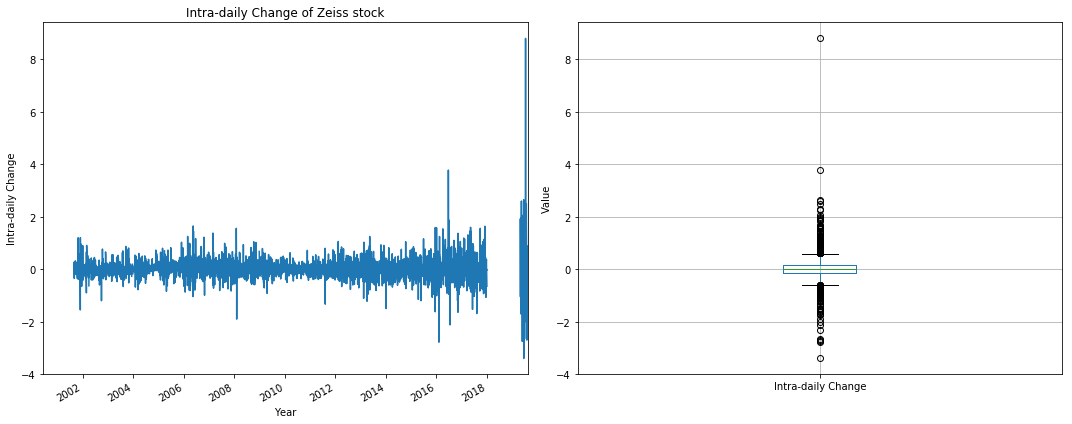

In [13]:
def plotting(x):
    #Setting figure size
    plt.figure(figsize=(15, 6))
    
    #Plotting a line plot over the years
    plt.subplot(1,2,1)
    f = data[x].plot(title=x + " of Zeiss stock")
    plt.xlabel('Year')
    plt.ylabel(x)
    
    #Plotting a boxplot to look for outliers
    plt.subplot(1,2,2)
    h = data.boxplot(column = x)
    plt.ylabel('Value')
    
    #Showing the result
    plt.tight_layout()
    plt.show()
    
# Traded volume
plotting('Intra-daily Change')

Generally, it appears that the intra-daily change is centered around 0 with some major fluctuations occurring recently (around the beginning of August 10th). Since the data fluctuates around the mean with no significant outliers, we can just fill in the null values with the mean of the column.

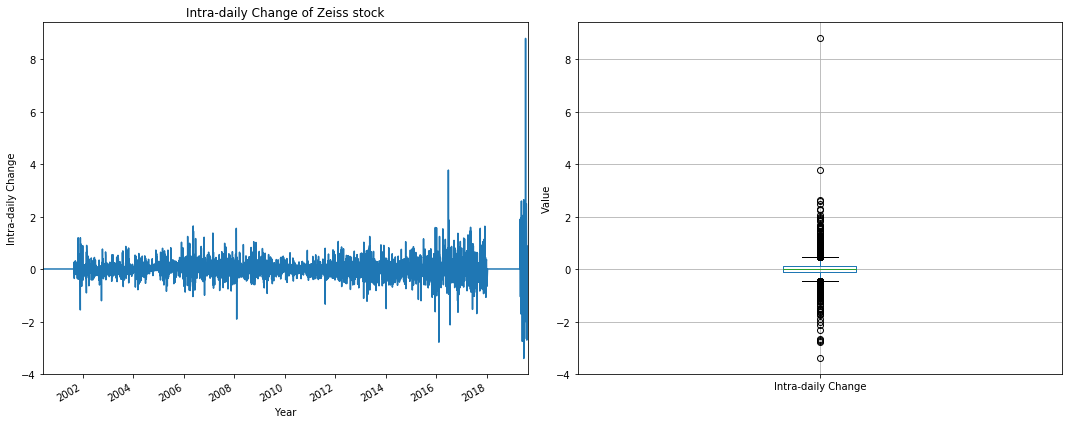

In [14]:
#We don't have a better way to fill in the missing values, so we can just use average
data['Intra-daily Change'] = data['Intra-daily Change'].fillna(value = data['Intra-daily Change'].mean())
plotting('Intra-daily Change')

As there is now no use for the open, high, and low columns, I deleted them.

In [15]:
data = data.drop(['Open','High','Low'],axis=1)

### Creating the "Inter-Daily Change" column.

We have intra-daily change, so it makes sense to create an "inter-daily change" column, with the percentage difference between each day's closing price and that of the day before, to contrast with the "intra-daily change" column. There should be no null values to fill aside from the most recent entry, because there were no unknown closing prices.

In [16]:
data['Inter-Daily Change'] = data['Close'].pct_change()*100
data['Inter-Daily Change'] = data['Inter-Daily Change'].fillna(value = 0)
data.head(10)

,Close,Intra-daily Change,Traded Volume,Turnover,Daily Turnover,Inter-Daily Change
Date,,,,,,
2019-08-12,98.95,-1.05,111146.0,11031779.0,NaN,0.000000
2019-08-09,99.05,-0.15,217386.0,21511178.0,NaN,0.101061
2019-08-08,95.10,-0.25,110482.0,10474803.0,NaN,-3.987885
2019-08-07,93.90,-0.25,119157.0,11200026.0,NaN,-1.261830
2019-08-06,93.25,-0.40,119714.0,11218618.0,NaN,-0.692226
2019-08-05,94.05,-2.30,232748.0,21909462.0,NaN,0.857909
2019-08-02,97.25,-2.70,124704.0,12224533.0,NaN,3.402446
2019-08-01,100.50,0.90,102399.0,10267086.0,NaN,3.341902
2019-07-31,99.45,0.45,106057.0,10535986.0,NaN,-1.044776


Let's take a look at the variation over time and in a box-and-whispers plot. Like the intra-daily change, the inter-daily change is mostly centered around 0. However, there appears to be more fluctuations in the past compared to recently.

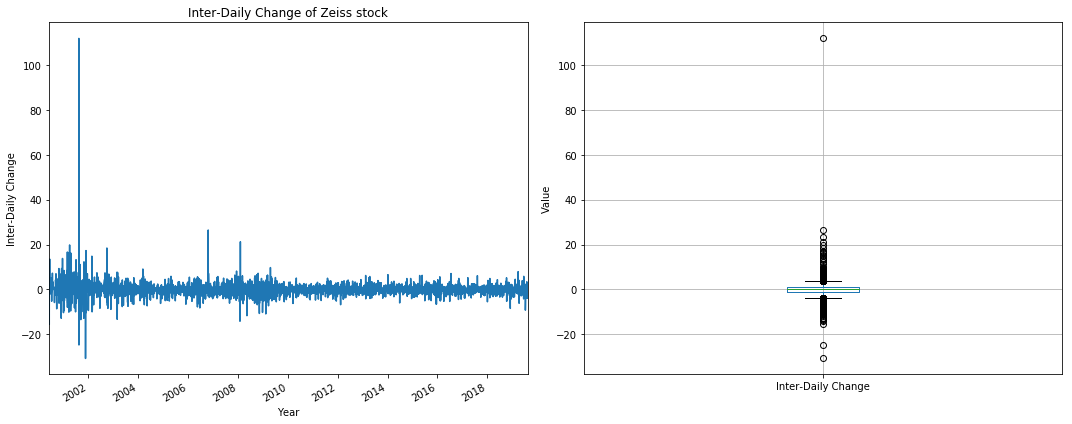

In [17]:
plotting('Inter-Daily Change')

### Combining Turnover and daily turnover

The Daily Turnover, theoretically, is a company's turnover in one day. However, Zeiss's turnover is already calculated on a daily basis, so I took a look at the values in both columns to see if there are any differences.

In [18]:
#What is the difference between Turnover and Daily Turnover?
data[data['Daily Turnover'].notnull()].head()

,Close,Intra-daily Change,Traded Volume,Turnover,Daily Turnover,Inter-Daily Change
Date,,,,,,
2010-01-01,12.46,0.010267,0.0,NaN,0.0,-0.399680
2009-12-31,12.46,0.010267,0.0,NaN,0.0,0.000000
2009-12-25,12.25,0.010267,0.0,NaN,0.0,0.657354
2009-12-24,12.25,0.010267,0.0,NaN,0.0,0.000000
2009-05-01,8.94,0.010267,0.0,NaN,0.0,-3.767492


In [19]:
data[data['Turnover'].notnull()].head()

,Close,Intra-daily Change,Traded Volume,Turnover,Daily Turnover,Inter-Daily Change
Date,,,,,,
2019-08-12,98.95,-1.05,111146.0,11031779.0,NaN,0.000000
2019-08-09,99.05,-0.15,217386.0,21511178.0,NaN,0.101061
2019-08-08,95.10,-0.25,110482.0,10474803.0,NaN,-3.987885
2019-08-07,93.90,-0.25,119157.0,11200026.0,NaN,-1.261830
2019-08-06,93.25,-0.40,119714.0,11218618.0,NaN,-0.692226


It seems that when turnover is NaN, Daily Turnover is 0.0 and there is no other difference. To see if this is true, we look at
columns where there are values for both.

In [20]:
data[data['Daily Turnover'].notnull() & data['Turnover'].notnull()]

,Close,Intra-daily Change,Traded Volume,Turnover,Daily Turnover,Inter-Daily Change
Date,,,,,,


It seems that there isn't any. Let's take a look at the .value_counts() for the daily turnover to see if there are any values aside from 0.

In [21]:
data['Daily Turnover'].value_counts()

0.0    1309
Name: Daily Turnover, dtype: int64

What does a 0 in Turnover mean? According to Google, when a company is *private both the traded volume and the turnover would be 0.* Perhaps Zeiss was a private company at one point. Thus, we would keep this information. 

So it looks like we can combine "Daily Turnover" and "Turnover" into one column, "Turnover", and replace some NaN values with 0.

In [22]:
mask2 = data['Daily Turnover'].notnull()
column_name = 'Turnover'
data.loc[mask2, column_name] = 0.0

data[data['Daily Turnover'].notnull()].head()

,Close,Intra-daily Change,Traded Volume,Turnover,Daily Turnover,Inter-Daily Change
Date,,,,,,
2010-01-01,12.46,0.010267,0.0,0.0,0.0,-0.399680
2009-12-31,12.46,0.010267,0.0,0.0,0.0,0.000000
2009-12-25,12.25,0.010267,0.0,0.0,0.0,0.657354
2009-12-24,12.25,0.010267,0.0,0.0,0.0,0.000000
2009-05-01,8.94,0.010267,0.0,0.0,0.0,-3.767492


In [23]:
data = data.drop('Daily Turnover', axis = 1)
data.head()

,Close,Intra-daily Change,Traded Volume,Turnover,Inter-Daily Change
Date,,,,,
2019-08-12,98.95,-1.05,111146.0,11031779.0,0.000000
2019-08-09,99.05,-0.15,217386.0,21511178.0,0.101061
2019-08-08,95.10,-0.25,110482.0,10474803.0,-3.987885
2019-08-07,93.90,-0.25,119157.0,11200026.0,-1.261830
2019-08-06,93.25,-0.40,119714.0,11218618.0,-0.692226


I'll look at the describe() of our combined Turnover column. 

In [24]:
data['Turnover'].describe()

count    4.891000e+03
mean     1.543648e+06
std      4.656318e+06
min      0.000000e+00
25%      0.000000e+00
50%      6.914330e+05
75%      1.529190e+06
max      2.584535e+08
Name: Turnover, dtype: float64

Then I'll, like above, graph the values over time and in a box-and-whiskers plot. It looks like the turnover is gradually increasing, so I'll fill in the missing values with 'ffill' to maintain the increasing trend. In addition, there is a significant outlier at approximately 2.5e8 that needs to be examined further.

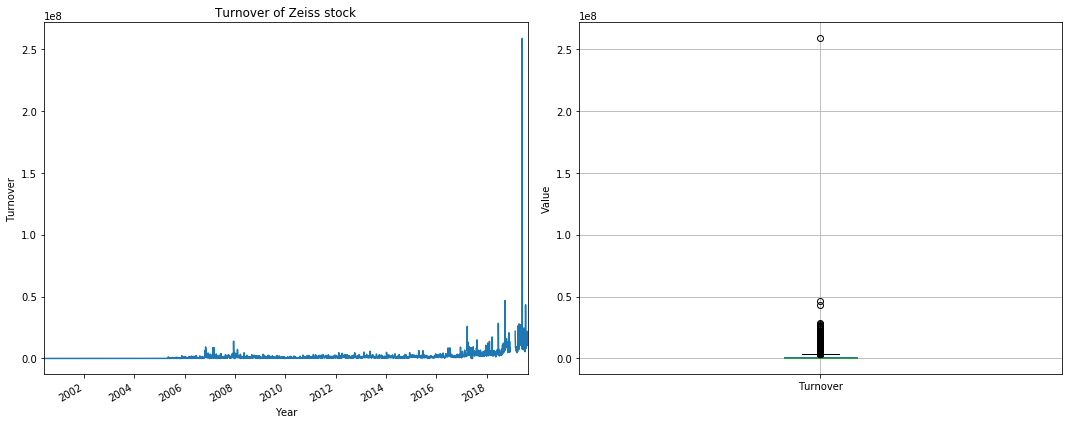

In [25]:
plotting('Turnover')

In [52]:
#Finding the row with the abnormally high Turnover
data['Turnover'] = data['Turnover'].fillna(method='ffill')
data.loc[data.index[data['Turnover'] == max(data['Turnover'])]]

,Close,Intra-daily Change,Traded Volume,Turnover,Inter-Daily Change,Date
Date,,,,,,
2019-05-28,87.4,-0.1,2957391.0,258453488.0,3.9239,2019-05-28


Turnover is the product of the closing price and the traded volume, which holds true in this case. It's entirely posible that the abnormally high turnover was simply the result of an abnormally profitable day for the company, and that there's nothing wrong with the data itself.

### Traded Volume.

As always, we take a look at the values over time and in a box and whiskers plot. The traded volume mostly reflects the same patterns seen in the turnover, so it makes sese to fill in missing values the same way using "ffill".

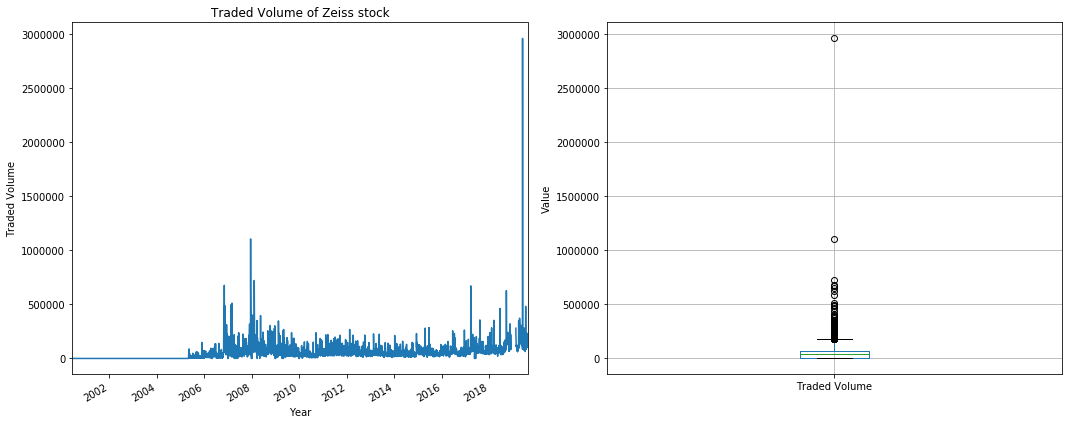

In [27]:
plotting('Traded Volume')

In [28]:
data['Traded Volume'] = data['Traded Volume'].fillna(method='ffill')

## Re-examining data after cleaning

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4937 entries, 2019-08-12 to 2000-06-07
Data columns (total 5 columns):
Close                 4937 non-null float64
Intra-daily Change    4937 non-null float64
Traded Volume         4937 non-null float64
Turnover              4937 non-null float64
Inter-Daily Change    4937 non-null float64
dtypes: float64(5)
memory usage: 391.4 KB


As compared to before, we've deleted some meaningless columns and filled all columns so that there are no null values.

In [53]:
data.describe()

,Close,Intra-daily Change,Traded Volume,Turnover,Inter-Daily Change
count,4937.000000,4937.000000,4.937000e+03,4.937000e+03,4937.000000
mean,22.590223,0.010267,5.494594e+04,1.733773e+06,0.018090
std,17.187561,0.366182,7.838248e+04,5.032237e+06,2.919175
min,4.070000,-3.400000,0.000000e+00,0.000000e+00,-30.769231
25%,11.360000,-0.110000,0.000000e+00,0.000000e+00,-0.956175
50%,16.400000,0.010267,3.941100e+04,7.031020e+05,0.000000
75%,24.930000,0.120000,7.403900e+04,1.568884e+06,0.948276
max,100.500000,8.800000,2.957391e+06,2.584535e+08,111.881188


# Visualizing data

### Quick visualization

I plan to include the following information in my final dashboard:
* Closing price, Turnover, Trading Volume, Inter- and Intra- daily change over time.
* Predictions of all of the above for two years.
* Patterns in the data within certain time frames (week, month, year)

In [31]:
from bokeh.io import output_file, show, curdoc
from bokeh.plotting import figure
from bokeh.models import Select, ColumnDataSource
from bokeh.layouts import row

In [ ]:
#Making the ColumnDataSource
CDS = ColumnDataSource(data)

In [57]:
#Making the glyphs
closing = figure()
closing.line(x = "Date", y = "Close", line_width=3, source=CDS)

GlyphRenderer(id='1908', ...)

In [60]:
menu = Select(options = ['Closing price', 'Turnover', 'Trading Volume', 'Inter-daily change', 'Intra- daily change'])
def update(attr, old, new):
    if menu.value == 'Trading Volume':
        closing.glyph.y = 'Trading Volume'
    elif menu.value == 'Turnover':
        closing.glyph.y = 'Turnover'
    else:
        closing.glyph.y = 'Close'
menu.on_change('options',update)
t = row(menu,closing)
curdoc().add_root(t)
show(t)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html



### Correlation

Below is a seaborn pairplot of every variable, with each column resampled by month because since if we show all of the data, everything will be too hectic. 

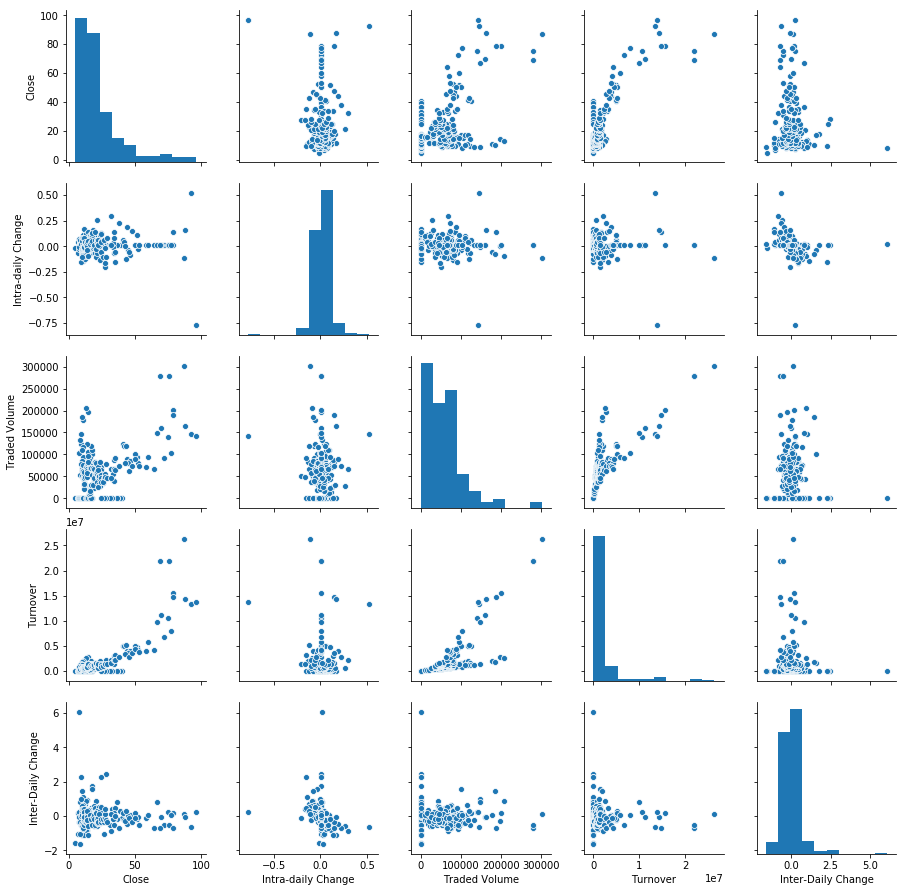

In [61]:
data_resampled = data.resample('M').mean()
sns.pairplot(data_resampled)
plt.show()

As you can see:
* All of the price variables highly correlate with each other, which makes sense since numbers from one column is used to calculate another.
* There is a slight positive correlation between turnover and the prices.
* There is a slight positive correlation between the traded volume and the prices. 
* There is a positive correlation between traded volume and turnover.
* There is a slight negative correlation between traded volume and turnover. 
* There is a slight negative correlation between inter-daily change and intra-daily change.

# Machine Learning Prediction

I tried training a few models to predict the daily closing price of ZEISS stock. Here, I used the closing price because that's the column with the least number of null values.

### Facebook Prophet

In [35]:
# Prophet requires columns ds (Date) and y (value)
gm = data.reset_index().rename(columns={'Date':'ds','Close': 'y'})
gm = gm[['ds','y']]
gm.shape

(4903, 2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
E:\Anaconda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


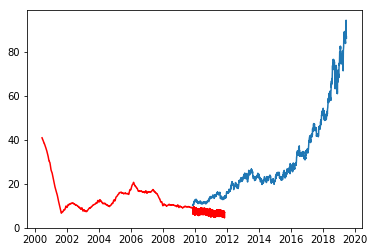

In [36]:
gm_1 = gm[2444:]
gm_2 = gm[:2444]

# Make the prophet model and fit on 1/2 of the data
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.5)
gm_prophet.fit(gm_1)

gm_forecast = gm_prophet.make_future_dataframe(periods=365*2, freq='D')
gm_forecast_pred = gm_prophet.predict(gm_forecast)

#Plot the results
plt.plot(gm_2['ds'],gm_2['y'])
plt.plot(gm_forecast_pred['ds'],gm_forecast_pred['yhat'], color='r')
plt.show()

In [38]:
#Accuracy of predicted
pred = gm_forecast_pred.iloc[::-1]['yhat'][:730]
true = gm_2['y'][-730:]
score = metrics.mean_squared_error(y_true = true, y_pred = pred)
score

57.759521162757636

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
E:\Anaconda\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Text(0.5, 1.0, 'Closing price of ZEISS Stock ')

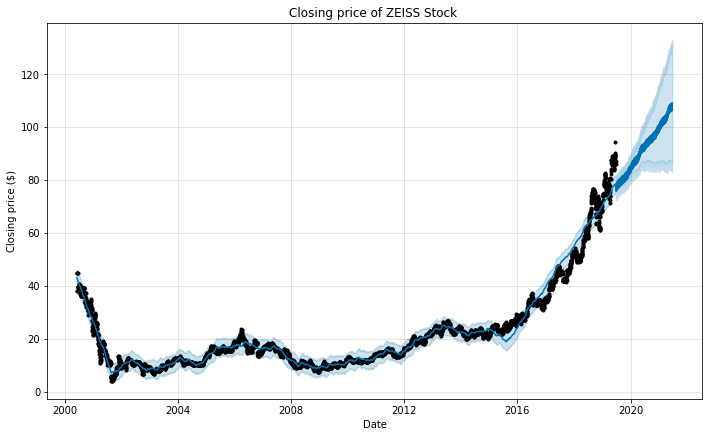

In [39]:
gm_prophet = fbprophet.Prophet(changepoint_prior_scale=0.5)
gm_prophet.fit(gm)

# Make predictions
gm_forecast = gm_prophet.make_future_dataframe(periods=365*2, freq='D')
gm_forecast_pred = gm_prophet.predict(gm_forecast)
gm_prophet.plot(gm_forecast_pred, xlabel = 'Date', ylabel = 'Closing price ($)')
plt.title('Closing price of ZEISS Stock ')

The black dots represent the company's actual closing prices, and the darker blue line represents the predictions made by our model. The lighter blue area represents the degree of uncertainty, which grows wider the further we get on the x-axis.